## Сбор данных с сайта "Яндекс Дзен"

In [2]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1670849776604%3Bfavorites-button:1',
    'yandex_login': '',
    'yandexuid': '1567321591669975581',
    'vid': '7b648543360b41b0',
    '_ym_uid': '1669976455916297376',
    '_ym_d': '1669976455',
    'tmr_lvid': '2cc769f3a6421595c1f27aed44e34bb3',
    'tmr_lvidTS': '1669976455070',
    '_yasc': '5hjEyBEv7lW/aE96TZ5a3IS5IHXQ/mfUv10DhL3BzlaaJgmrS3tMLzS5oLc=',
    'mda2_beacon': '1671112506715',
    'zen_sso_checked': '1',
    'vsd': 'eyJnZW8iOiIxODgiLCJ1YSI6IkNIUk9NRSIsImVhIjo0MSwiZWciOjJ9',
    '_ym_isad': '2',
    'tmr_detect': '0%7C1671612765927',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
    # 'Cookie': 'news_lang=ru; nc=tips=1670849776604%3Bfavorites-button:1; yandex_login=; yandexuid=1567321591669975581; vid=7b648543360b41b0; _ym_uid=1669976455916297376; _ym_d=1669976455; tmr_lvid=2cc769f3a6421595c1f27aed44e34bb3; tmr_lvidTS=1669976455070; _yasc=5hjEyBEv7lW/aE96TZ5a3IS5IHXQ/mfUv10DhL3BzlaaJgmrS3tMLzS5oLc=; mda2_beacon=1671112506715; zen_sso_checked=1; vsd=eyJnZW8iOiIxODgiLCJ1YSI6IkNIUk9NRSIsImVhIjo0MSwiZWciOjJ9; _ym_isad=2; tmr_detect=0%7C1671612765927',
    'Referer': 'https://dzen.ru/news/rubric/society?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Google Chrome";v="108"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам

In [2]:
def parse_rubrics():
    rubrics = ['Политика', 'Армия и оружие', 'Общество', 'ЖКХ', 'Религия', 'Экология', 'Здоровье', 'Путешествия', 
               'Транспорт', 'Экономика', 'Энергетика', 'Недвижимость', 'Финансы', 'В мире', 'Спорт', 'Автоспорт',
               'Баскетбол', 'Футбол', 'Хоккей', 'Фигурное катание', 'Происшествия', 'Культура', 'Театры', 'Музыка',
               'Кино', 'Технологии', 'Игры', 'Гаджеты', 'Интернет', 'Наука', 'Космос']
    rubrics_links = ['rubric/politics', 'rubric/army', 'rubric/society', 'rubric/communal', 'rubric/religion',
                     'rubric/ecology', 'rubric/health', 'rubric/travels', 'rubric/vehicle',  'rubric/business',
                     'rubric/energy', 'rubric/realty', 'rubric/finances', 'rubric/world', 'rubric/sport',
                     'rubric/auto_racing', 'rubric/basketball', 'rubric/football', 'rubric/hockey',
                     'rubric/figure_skating', 'rubric/incident', 'rubric/culture', 'rubric/theaters',
                     'rubric/music', 'rubric/movies', 'rubric/computers', 'rubric/games', 'rubric/gadgets',
                     'rubric/internet', 'rubric/science', 'rubric/cosmos']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

### Сбор похожих новостей при переходе к каждой новости (instory) (с рубриками и подрубриками)

In [3]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
            
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)
    
    main_rubrics = []
    for i, row in df_more_stories.iterrows():
        if row['rubric'] == 'Политика' or row['rubric'] == 'Армия и оружие':
            main_rubric = 'Политика'
        elif row['rubric'] == 'Общество' or row['rubric'] == 'ЖКХ' or row['rubric'] == 'Религия' or row['rubric'] == 'Экология' or row['rubric'] == 'Здоровье' or row['rubric'] == 'Путешествия' or row['rubric'] == 'Транспорт':
            main_rubric = 'Общество'
        elif row['rubric'] == 'Экономика' or row['rubric'] == 'Энергетика' or row['rubric'] == 'Недвижимость' or row['rubric'] == 'Финансы':
            main_rubric = 'Экономика'
        elif row['rubric'] == 'В мире':
            main_rubric = 'В мире'
        elif row['rubric'] == 'Спорт' or row['rubric'] == 'Автоспорт' or row['rubric'] == 'Баскетбол' or row['rubric'] == 'Футбол' or row['rubric'] == 'Хоккей' or row['rubric'] == 'Фигурное катание':
            main_rubric = 'Спорт'
        elif row['rubric'] == 'Происшествия':
            main_rubric = 'Происшествия'
        elif row['rubric'] == 'Культура' or row['rubric'] == 'Театры' or row['rubric'] == 'Музыка' or row['rubric'] == 'Кино':
            main_rubric = 'Культура'
        elif row['rubric'] == 'Технологии' or row['rubric'] == 'Игры' or row['rubric'] == 'Гаджеты' or row['rubric'] == 'Интернет':
            main_rubric = 'Технологии'
        elif row['rubric'] == 'Наука' or row['rubric'] == 'Космос':
            main_rubric = 'Наука'
        else:
            main_rubric = 'Другое'
        
        main_rubrics.append(main_rubric)
                             
    df_more_stories.insert(loc=0, column='main_rubric', value=main_rubrics)
    return df_more_stories

### Сбор похожих новостей (только с рубриками)

In [4]:
def parse_main_1():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
        
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)

    return df_more_stories

## Разведочный анализ данных

In [3]:
#%%time
#df_parse = parse_main()
df_nlp = pd.read_excel(r'/Users/user/Documents/test.xlsx')
df_nlp = df_nlp.loc[:, ['rubric','title','text']]

df_nlp

,rubric,title,text
0,Политика,Песков: для начала переговоров с Украиной нужн...,"Для того, чтобы начался дальнейший переговорны..."
1,Политика,Песков: Москва ожидает готовность Киева обсужд...,Официальный представитель Кремля Дмитрий Песко...
2,Политика,"В Кремле объяснили, почему продолжается спецоп...",Представитель Кремля Дмитрий Песков сообщил об...
3,Политика,Кремль: для начала переговоров с Украиной нужн...,"Представитель Кремля заявил, что, помимо преод..."
4,Политика,Песков: для начала переговоров России и Украин...,Официальный представитель Кремля Дмитрий Песко...
...,...,...,...
256325,Наука,Американский посадочный модуль InSight на Марс...,Стационарный посадочный модуль InSight был дос...
256326,Наука,Устройство для развития растений в космосе без...,"Устройство, позволяющее выращивать растения в ..."
256327,Наука,Первый запуск новой японской ракеты-носителя H...,Новую японскую ракету-носитель тяжелого класса...
256328,Наука,Первый запуск новой японской ракеты H3 может с...,"Первый запуск новой ракеты-носителя H3, котора..."


In [7]:
# Информация о данных
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256330 entries, 0 to 256329
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rubric  256330 non-null  object
 1   title   256330 non-null  object
 2   text    256330 non-null  object
dtypes: object(3)
memory usage: 5.9+ MB


<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [8]:
# Статистика распределения значений в столбце rubric в % виде
df_nlp['rubric'].value_counts(normalize=True)

Политика        0.251945
Общество        0.188012
Происшествия    0.170440
Спорт           0.121952
Экономика       0.092533
В мире          0.058811
Культура        0.056525
Технологии      0.031655
Наука           0.028128
Name: rubric, dtype: float64

In [8]:
# Исследование столбца rubric
print('Кол-во уникальных значений: ', df_nlp['rubric'].nunique())
print('Список уникальных значений: ', df_nlp['rubric'].unique())
print('Статистика распределения значений: ', df_nlp['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Происшествия' 'В мире' 'Экономика' 'Спорт'
 'Технологии' 'Культура' 'Наука']
Статистика распределения значений:  Политика        64581
Общество        48193
Происшествия    43689
Спорт           31260
Экономика       23719
В мире          15075
Культура        14489
Технологии       8114
Наука            7210
Name: rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [9]:
# Описательная статистика для всех признаков 
df_nlp.describe().T

,count,unique,top,freq
rubric,256330,9,Политика,64581
title,256330,240375,Умер бывший председатель КНР Цзян Цзэминь,33
text,256330,249258,Заметка дополняется...,34


### Визульный анализ

<AxesSubplot:>

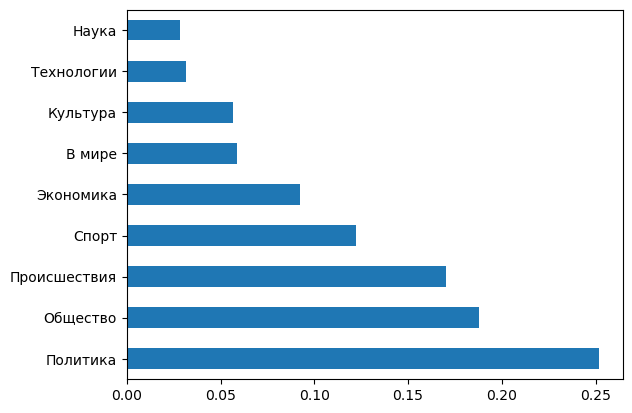

In [4]:
# Горизонтальная столбчатая диаграмма для столбца rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

## Обработка естественного языка NLP

Действия, выполняемые в процессе:

* удаление пробельных символов;
* стемминг;
* удаление стоп-слов;
* лемматизация.

In [20]:
# Функция для удаления пробельных символов
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(df): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) 
                 for text in df['text']]
    prep_title = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))
                  for text in df['title']]
    df["text_prep"] = prep_text
    df["title_prep"] = prep_title
    return df


# Функция для стемматизации
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text(df):
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    stemmed_titles_list = []
    
    for text in df["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df["text_stem"] = stemmed_texts_list
    
    for text in df["title_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_titles_list.append(text)
    
    df["title_stem"] = stemmed_titles_list
    
    return df


# Функция для удаления стоп-слов
from nltk import word_tokenize

def stopword_text(df):
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    
    sw_texts_list = []
    sw_titles_list = []
    
    for text in df['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df["text_sw"] = sw_texts_list
    
    for text in df['title_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_titles_list.append(text)
        
    df["title_sw"] = sw_titles_list
    
    return df


# Функция для лемматизации
from pymystem3 import Mystem
from tqdm import tqdm

def lemmatize_text(df):
    mystem = Mystem()
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    lemm_texts_list = []
    lemm_titles_list = []
    
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart1 = lol(df['text_sw'], 10000)
    txtpart2 = lol(df['title_sw'], 10000)
    
    for txtp in tqdm(txtpart1):
        alltexts = ' joining '.join(txtp)
        words = mystem.lemmatize(alltexts)
        tokens = [token for token in words if token != '\n' and token != ' ' and token not in russian_stopwords]
        text = ' '.join(tokens)
        lemm_texts_list += text.split('joining')

    for txtp in tqdm(txtpart2):
        alltexts = ' joining '.join(txtp)
        words = mystem.lemmatize(alltexts)
        tokens = [token for token in words if token != '\n' and token != ' ' and token not in russian_stopwords]
        text = ' '.join(tokens)
        lemm_titles_list += text.split('joining')

    df["text_lemm"] = lemm_texts_list
    df["title_lemm"] = lemm_titles_list
    
    return df


# Функция для обработки естественного языка
def nlp(df):
    #df = df
    delete_char(df)
    stemmed_text(df)
    stopword_text(df)
    lemmatize_text(df)
    
    return df

In [25]:
%%time
df_nlp = nlp(df_nlp)

100%|███████████████████████████████████████████| 26/26 [13:25<00:00, 31.00s/it]

CPU times: user 59min 22s, sys: 2min 7s, total: 1h 1min 30s
Wall time: 1h 5min 8s


In [27]:
df_nlp

,rubric,title,text,text_prep,title_prep,text_stem,title_stem,text_sw,title_sw,text_lemm,title_lemm
0,Политика,Песков: для начала переговоров с Украиной нужн...,"Для того, чтобы начался дальнейший переговорны...",для того чтобы начался дальнейший переговорный...,песков для начала переговоров с украиной нужна...,нача дальн переговорн процесс росс украин ки д...,песк нача переговор украин нужн политическ вол...,начался дальнейший переговорный процесс россии...,песков начала переговоров украиной нужна полит...,начинаться дальнейший переговорный процесс рос...,песков начало переговоры украина нужный полити...
1,Политика,Песков: Москва ожидает готовность Киева обсужд...,Официальный представитель Кремля Дмитрий Песко...,официальный представитель кремля дмитрий песко...,песков москва ожидает готовность киева обсужда...,официальн представител кремл дмитр песк заяв к...,песк москв ожида готовн киев обсужда ран озвуч...,официальный представитель кремля дмитрий песко...,песков москва ожидает готовность киева обсужда...,официальный представитель кремль дмитрий песо...,песок москва ожидать готовность киев обсуждат...
2,Политика,"В Кремле объяснили, почему продолжается спецоп...",Представитель Кремля Дмитрий Песков сообщил об...,представитель кремля дмитрий песков сообщил об...,в кремле объяснили почему продолжается спецопе...,представител кремл дмитр песк сообщ отсутств п...,кремл объясн поч продолжа спецоперац украин,представитель кремля дмитрий песков сообщил от...,кремле объяснили почему продолжается спецопера...,представитель кремль дмитрий песок сообщать о...,кремль объяснять почему продолжаться спецопер...
3,Политика,Кремль: для начала переговоров с Украиной нужн...,"Представитель Кремля заявил, что, помимо преод...",представитель кремля заявил что помимо преодол...,кремль для начала переговоров с украиной нужна...,представител кремл заяв помим преодолен законо...,кремл нача переговор украин нужн политическ во...,представитель кремля заявил помимо преодоления...,кремль начала переговоров украиной нужна полит...,представитель кремль заявлять помимо преодоле...,кремль начало переговоры украина нужный полит...
4,Политика,Песков: для начала переговоров России и Украин...,Официальный представитель Кремля Дмитрий Песко...,официальный представитель кремля дмитрий песко...,песков для начала переговоров россии и украины...,официальн представител кремл дмитр песк заяв н...,песк нача переговор росс украин нужн политичес...,официальный представитель кремля дмитрий песко...,песков начала переговоров россии украины нужна...,официальный представитель кремль дмитрий песо...,песок начинать переговоры россия украина нужн...
...,...,...,...,...,...,...,...,...,...,...,...
256325,Наука,Американский посадочный модуль InSight на Марс...,Стационарный посадочный модуль InSight был дос...,стационарный посадочный модуль insight был дос...,американский посадочный модуль insight на марс...,стационарн посадочн модул insight доставл марс...,американск посадочн модул insight марс переста...,стационарный посадочный модуль insight доставл...,американский посадочный модуль insight марсе п...,стационарный посадочный модуль insight достав...,американский посадочный модуль insight марс п...
256326,Наука,Устройство для развития растений в космосе без...,"Устройство, позволяющее выращивать растения в ...",устройство позволяющее выращивать растения в к...,устройство для развития растений в космосе без...,устройств позволя выращива растен космос автон...,устройств развит растен космос участ человек з...,устройство позволяющее выращивать растения кос...,устройство развития растений космосе участия ч...,устройство позволять выращивать растение косм...,устройство развитие растение космос участие ч...
256327,Наука,Первый запуск новой японской ракеты-носителя H...,Новую японскую ракету-носитель тяжелого класса...,новую японскую ракету носитель тяжелого класса...,первый запуск новой японской ракеты носителя h...,нов японск ракет носител тяжел класс h планир ...,перв запуск нов япо

### Сохранение данных в формате csv

In [28]:
# Для mac
df_nlp.to_csv('/Users/user/Documents/ML.csv')

# Для win
#df_nlp.to_csv(r'C:\Users\User\Downloads\ML.csv')
# Выражение, добавляющее к БД только новые новости
#res = df1[~df1['url'].isin(df2['url'])]